<a href="https://colab.research.google.com/github/VidushiBhatia/XGBoost-heirarchical-local-classifiers/blob/main/Heirarchical_Classification_with_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Heirarchical Classification with XGBoost

## Objective

The given dataset contains information about various companies that belong to different industries and industry types. Each of these companies has some products that they offer in the market. Perform heirarchical classification to **predict industry, type, and product.**

Some companies may not have products, predict None for such cases.

<a name='1'></a>
## 1. Packages

In [1]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

## 2. Get access to the DataFiles

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# '/content/drive/My Drive/4a4a221c-e-dataset.zip'
!rm -rf dataset
!ls -al
!unzip /content/drive/My\ Drive/4a4a221c-e-dataset.zip > /dev/null

total 24
drwxr-xr-x 1 root root 4096 Jul 18 11:26 .
drwxr-xr-x 1 root root 4096 Jul 18 07:11 ..
drwxr-xr-x 4 root root 4096 Jul 15 13:37 .config
drwx------ 5 root root 4096 Jul 18 07:14 drive
drwxr-xr-x 2 root root 4096 Jul 18 07:35 .ipynb_checkpoints
drwxr-xr-x 1 root root 4096 Jul 15 13:38 sample_data


## 3. Data Pre-Processing



In [4]:
############################################ Helper Function 1 ############################################################

def MergeCSVFiles(path, industry_flag=False):
  """
  Helper Function to read and merge CSV files
  """
  df = pd.DataFrame()
  files = os.listdir(path) 
  missing_value_formats = ["n.a.","?","NA","n/a", "na", "--"]
  
  for file in files:
    if file.endswith('.csv'):
      temp = pd.read_csv(os.path.join(path,file), na_values = missing_value_formats)
      if industry_flag:
        temp['Industry'] = file[:file.find("_")]
      df = df.append(temp).reset_index(drop=True)
  return df


############################################ Helper Function 2 ############################################################
 
def MergeTXTFiles(path, master_df):
  """
  Helper Function to read and merge TXT files
  """
  row_list = []
 
  files = os.listdir(path) 

  for file in files:
    if file.endswith('.txt'):
      df_dict = {}
      df_dict['ID'] = file[:file.find(".")]
      with open(os.path.join(path,file),'rb') as temp:
        df_dict['Product_Information'] = temp.read()
        df_dict['Product_Information'] = df_dict['Product_Information'].decode('utf-8', 'ignore')
        # df_dict['Product_Information'] = unicode(df_dict['Product_Information'], errors='ignore')
        row_list.append(df_dict)
  df = pd.DataFrame(row_list)
  master_df = master_df.merge(df, how='left', on='ID')
  return master_df

In [5]:
# STEP 1 - Read all CSV files
train_df = MergeCSVFiles('./dataset/train/', True)
test_df = MergeCSVFiles('./dataset/test/', False)
sample_submission_df = MergeCSVFiles('./dataset/', False)

# STEP 2 - Read all TXT files
train_df = MergeTXTFiles('./dataset/train/product_info/', train_df)
test_df = MergeTXTFiles('./dataset/test/product_info/', test_df)

# Quick check of % missing values
print("\n Train DF:\n", train_df.isnull().sum()/len(train_df))
print("\n Test DF:\n", test_df.isnull().sum()/len(test_df))



 Train DF:
 ID                     0.000000
Symbol                 0.726254
Start_date             0.631478
market_cap             0.505751
Sector                 0.513070
Country                0.849011
CEO                    0.637417
No.of employee         0.599983
Revenue (Cr)           0.183529
Net-valuation (Cr)     0.335146
Share_price (RS)       0.185704
Company_background     0.003513
Type                   0.003137
Product                0.000000
Industry               0.000000
Product_Information    0.000000
dtype: float64

 Test DF:
 ID                     0.000000
Symbol                 0.728508
Start_date             0.630711
market_cap             0.503210
Sector                 0.521208
Country                0.855821
CEO                    0.629641
No.of employee         0.604594
Revenue (Cr)           0.180931
Net-valuation (Cr)     0.325110
Share_price (RS)       0.182064
Company_background     0.003084
Product_Information    0.000000
dtype: float64


## 4. Exploratory Data Analysis

In [6]:
# Summaries of the databases
train_df.describe()

,No.of employee,Revenue (Cr),Net-valuation (Cr),Share_price (RS)
count,9564.000000,19521.000000,15896.000000,19469.000000
mean,24893.030217,-250.159364,1998.416353,402.239558
std,21818.740348,442.534449,13769.866535,3043.306601
min,1.000000,-999.000000,-91524.892623,-23276.406748
25%,6928.750000,-999.000000,188.801514,54.450000
50%,18509.000000,4.052455,1101.247801,332.550000
75%,38382.000000,12.936895,4404.665252,890.500000
max,97590.000000,64.925988,83237.474347,20480.908699


In [7]:
# Summaries of the databases - The distribution of both train and test should be similar
test_df.describe()

,No.of employee,Revenue (Cr),Net-valuation (Cr),Share_price (RS)
count,6283.00000,13015.000000,10724.000000,12997.000000
mean,25353.37498,-252.848582,1784.464278,412.172388
std,22213.08645,443.897052,13997.977176,3104.092044
min,0.00000,-999.000000,-81292.653220,-20251.986242
25%,6713.50000,-999.000000,164.314856,56.600000
50%,19461.00000,4.019814,1007.281953,345.500000
75%,38987.00000,12.711707,4172.771949,905.050000
max,99503.00000,64.667160,92961.424539,22502.173996


In [8]:
# check if the n szie of groups is sufficient
train_df.groupby(['Industry']).agg({'Industry':'count', 'Type': 'count', 'Product':'count'})

,Industry,Type,Product
Industry,,,
automobile,4807,4791,4807
computer,4828,4819,4828
health,4698,4679,4698
manufacturing,4837,4826,4837
power,4739,4719,4739


In [9]:
train_df.groupby(['Industry', 'Type']).agg({'Industry':'count', 'Type': 'count', 'Product':'count'})

Industry  Type  Product
Industry      Type                                     
automobile    Heavy Vehicles        1585  1585     1585
              Heavy vehicle            1     1        1
              Light Vehicles        3205  3205     3205
computer      Hardware              1441  1441     1441
              Security               954   954      954
              Software              2424  2424     2424
health        Diagnostic            1557  1557     1557
              Pharma                3122  3122     3122
manufacturing Food                  1560  1560     1560
              Mechanical            1086  1086     1086
              Production            1651  1651     1651
              Toys                   529   529      529
power         green energy          2825  2825     2825
              non green energy      1894  1894     1894

In [10]:
train_df.groupby(['Industry', 'Type', 'Product']).agg({'Industry':'count', 'Type': 'count', 'Product':'count'})

Industry  Type  Product
Industry      Type             Product                                      
automobile    Heavy Vehicles   JCP                        793   793      793
                               None                         8     8        8
                               Truck                      784   784      784
              Heavy vehicle    Truck                        1     1        1
              Light Vehicles   AI                         797   797      797
                               Bike                       879   879      879
                               Car                        756   756      756
                               None                         5     5        5
                               Truck                      768   768      768
computer      Hardware         AI                         495   495      495
                               Gaming hardware            487   487      487
                               Hardware accelerator       456   456      456
                               None                         3     3        3
              Security         Cyber-security             457   457      457
                               None                         2     2        2
                               antivirus-security         495   495      495
              Software         AI                         501   501      501
                               Cyber-security             499   499      499
                               Hardware accelerator       469   469      469
                               IT                         473   473      473
                               None                        11    11       11
                               antivirus-security         471   471      471
health        Diagnostic       Medical devices            757   757      757
                               None                         4     4        4
                               allopathy                  796   796      796
              Pharma           None                        10    10       10
                               Organicfood                722   722      722
                               allopathy                  789   789      789
                               homeopathic                782   782      782
                               siddha                     819   819      819
manufacturing Food             Beverage                   510   510      510
                               Fastfood                   566   566      566
                               None                         4     4        4
                               Organicfood                480   480      480
              Mechanical       Kids toys                  547   547      547
                               None                         4     4        4
                               Wiring tools               535   535      535
              Production       Bike                       533   533      533
                               Gaming hardware            558   558      558
                               Medical devices            555   555      555
                               None                         5     5        5
              Toys             Kids toys                  527   527      527
                               None                         2     2        2
power         green energy     Hydro                      940   940      940
                               None                         9     9        9
                               Solar                     1004  1004     1004
                               Wind                       872   872      872
              non green energy Fuel                       944   944      944
                               None                         5     5        5
                               charcoal                   945   945      945

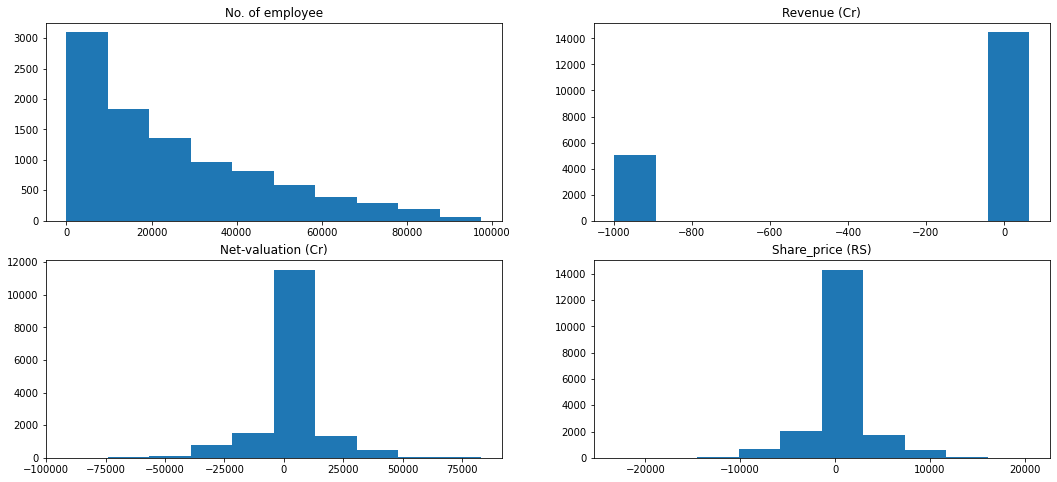

In [11]:
# Look at the distributions of the quant variables
fig, ax = plt.subplots(2,2, figsize=(18, 8))
ax[0,0].hist(train_df['No.of employee'])
ax[0,0].set_title('No. of employee')
ax[0,1].hist(train_df['Revenue (Cr)'])
ax[0,1].set_title('Revenue (Cr)')
ax[1,0].hist(train_df['Net-valuation (Cr)'])
ax[1,0].set_title('Net-valuation (Cr)')
ax[1,1].hist(train_df['Share_price (RS)'])
ax[1,1].set_title('Share_price (RS)')
plt.show()

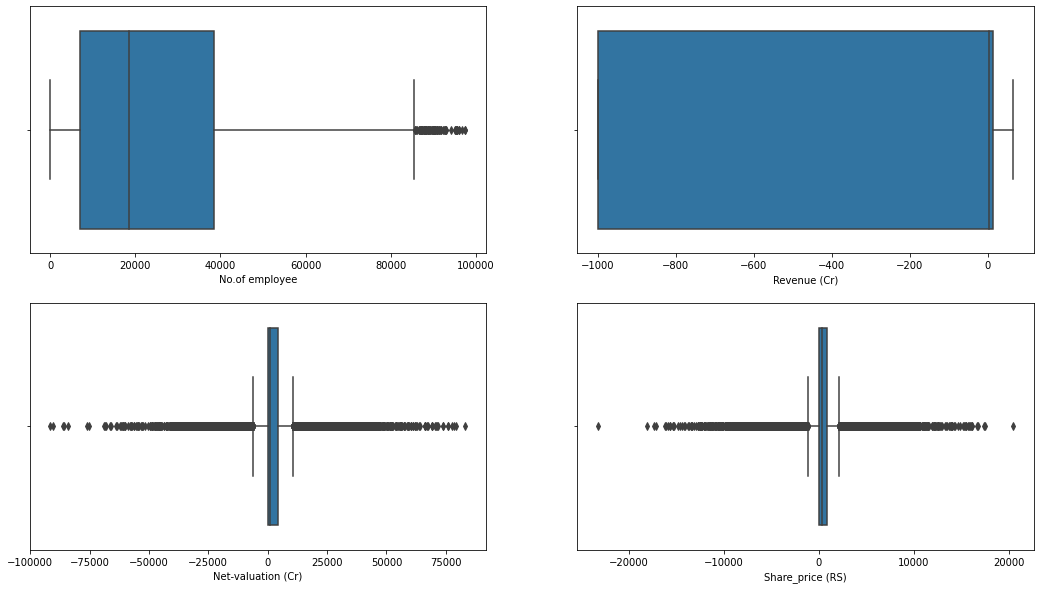

In [12]:
# outliers
fig, ax1 = plt.subplots(2,2, figsize=(18, 10))
sns.boxplot(x=train_df['No.of employee'], ax=ax1[0,0])
# ax1[0,0].boxplot(x=train_df['No.of employee'])
sns.boxplot(x=train_df['Revenue (Cr)'], ax=ax1[0,1])
# ax1[0,1].set_title('Revenue (Cr)')
sns.boxplot(x=train_df['Net-valuation (Cr)'], ax=ax1[1,0])
# ax1[1,0].set_title('Net-valuation (Cr)')
sns.boxplot(x=train_df['Share_price (RS)'], ax=ax1[1,1])
# ax1[1,1].set_title('Share_price (RS)')
plt.show()

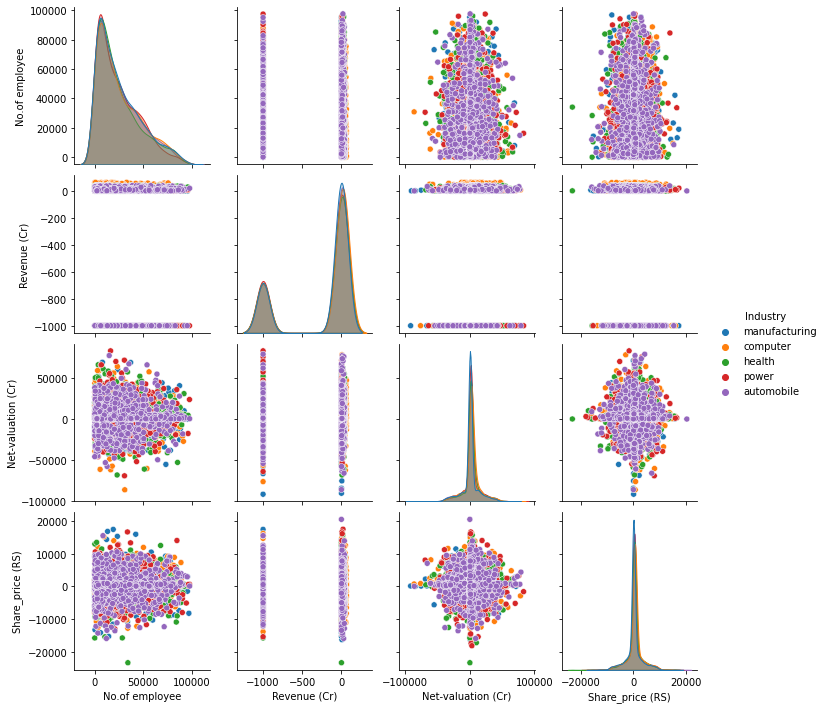

In [13]:
# quant data with all prediction variables
sns.pairplot(train_df, hue='Industry')

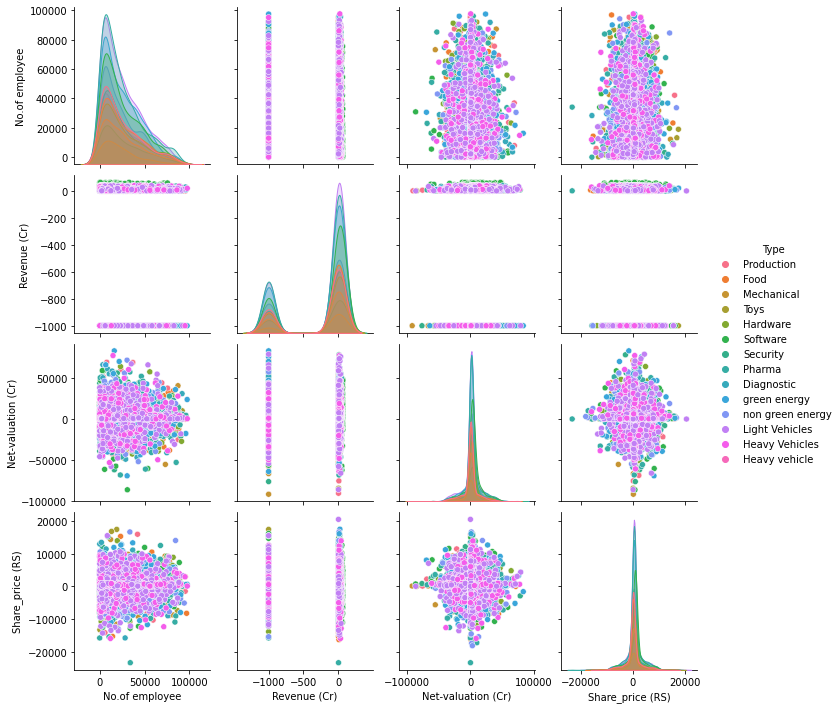

In [14]:
# quant data with all prediction variables
sns.pairplot(train_df, hue='Type')

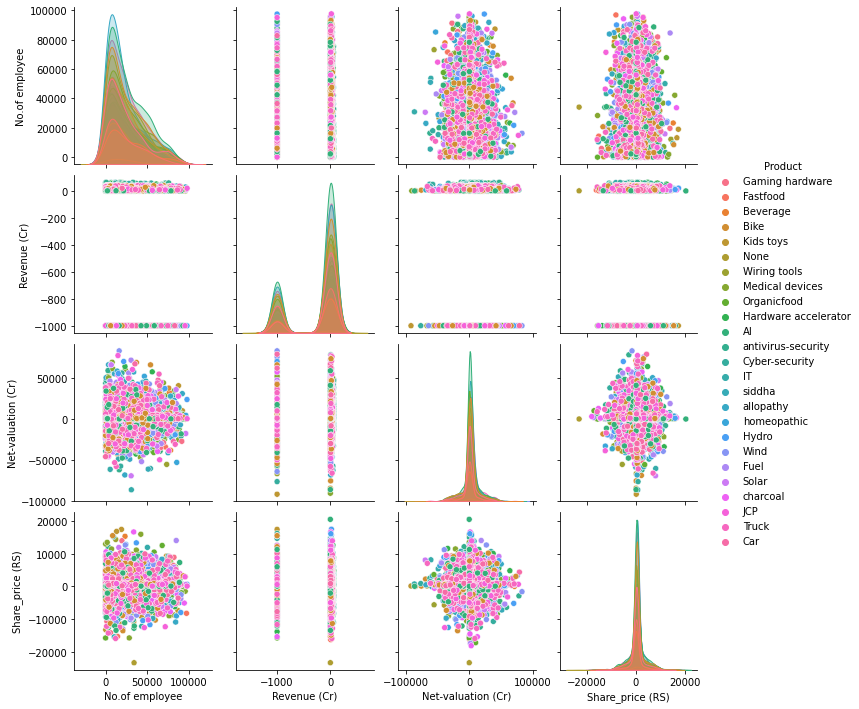

In [15]:
# quant data with all prediction variables
sns.pairplot(train_df, hue='Product')

## 5. Feature Engineering

* 'ID': Identifier
* 'Symbol': Very high missing values
* 'Start_date': high missing values, **can convert to days passed till today**
* 'market_cap': **one hot encoding**
* 'Sector': **one hot encoding**
* 'Country': too many missing values
* 'CEO': does not make sense to use
* 'No.of employee': dist looks fine, maybe try outlier treatment if required, **try squaring**
* 'Revenue (Cr)': **log transformation required**, **try squaring**
* 'Net-valuation (Cr)': distribution is concentrated at the center, **cap with outlier analysis, try squaring**
* 'Share_price (RS)': : distribution is concentrated at the center, **cap with outlier analysis, try squaring**
* 'Company_background': **text classification**
* 'Product Information': **text classification**
* 'Type': y variable - correct 'heavy vehicle'
* 'Product': y variable
* 'Industry': y variable

In [16]:
############################################ Helper Function 3 ############################################################
def cat_to_id(input):
  "function to convert categorical variables into ordinal numbers"
  label = {}
  for index, value in enumerate(input.unique()):
    label[value] = index
  return label

In [17]:
############################################ Helper Function 4 ############################################################
def TextClassifier(text_data,label):
  "function to create text classifier for a set of data and labels"
  text_clf = Pipeline([ ('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
          ('clf', MultinomialNB())])
  text_clf = text_clf.fit(text_data, label)
  return text_clf


############################################ Helper Function 5 ############################################################
def TextClassificationCompile(data):
    "function to make multiple classifiers and combine them into a dict"    
    # TEXT CLASSIFICATION 1: 'Company_background' and y variables
    text_classification = data[pd.notnull(data['Company_background'])]
    text_classification = text_classification[['ID','Company_background','industry_y','type_y','product_y']]
    clf_model_back_industry = TextClassifier(text_classification.Company_background, text_classification.industry_y)
    clf_model_back_type = TextClassifier(text_classification.Company_background, text_classification.type_y)
    clf_model_back_prod = TextClassifier(text_classification.Company_background, text_classification.product_y)

    # TEXT CLASSIFICATION 2: 'Product_Information' and y variables
    prod_text_classification = data[pd.notnull(data['Product_Information'])]
    prod_text_classification = prod_text_classification[['ID','Product_Information','industry_y','type_y','product_y']]
    clf_model_info_industry = TextClassifier(prod_text_classification.Product_Information, prod_text_classification.industry_y)
    clf_model_info_type = TextClassifier(prod_text_classification.Product_Information, prod_text_classification.type_y)
    clf_model_info_prod = TextClassifier(prod_text_classification.Product_Information, prod_text_classification.product_y)

    clf_dict = {'clf_model_back_industry':clf_model_back_industry,
                'clf_model_back_type':clf_model_back_type,
                'clf_model_back_prod': clf_model_back_prod,
                'clf_model_info_industry': clf_model_info_industry,
                'clf_model_info_type': clf_model_info_type,
                'clf_model_info_prod': clf_model_info_prod}

    return clf_dict

In [18]:
############################################ Helper Function 6 ############################################################
def FeatureEngg(data, train=False):
    # DERIVED METRIC : Days
    data['days_since_start'] = (np.datetime64(datetime.today().date()) - 
                                          pd.to_datetime(data['Start_date'], errors = 'coerce'))
    data.days_since_start = data.days_since_start.apply(lambda x: x.days)

    # One hot encodings
    data = data.merge(pd.get_dummies(data['market_cap']), how='left', left_index=True, right_index=True)
    data = data.merge(pd.get_dummies(data['Sector']), how='left', left_index=True, right_index=True)

    # outlier analysis
    quant_cols = ['No.of employee','Net-valuation (Cr)','Share_price (RS)','Revenue (Cr)']
    for col in quant_cols:
      val =  (np.mean(data[col]) + 3*np.std(data[col]))
      print ("capped:", sum (data[col] > val))
      data[col+"_capped"] = np.minimum(val,data[col])
    
    # log transformation and square
    data['log_revenue'] = np.log(data['Revenue (Cr)'])
    data['sq_revenue'] = np.square(data['Revenue (Cr)'])
    data['sq_employees'] = np.square(data['No.of employee'])
    data['sq_valuation'] = np.square(data['Net-valuation (Cr)'])
    data['sq_share_price'] = np.square(data['Share_price (RS)'])
    
    ind_dict = {'manufacturing' : 0 , 'computer' : 1 , 'health' : 2 , 'power' : 3 , 'automobile' : 4}
    type_dict = {'production' : 0 , 'food' : 1 , 'mechanical' : 2 , 'toys' : 3 , 'none' : 4 , 'hardware' : 5 ,
                 'software' : 6 , 'security' : 7 , 'pharma' : 8 , 'diagnostic' : 9 , 'green energy' : 10 , 
                 'non green energy' : 11 , 'light vehicles' : 12 , 'heavy vehicles' : 13 }
    prod_dict = {'gaming hardware' : 0 , 'fastfood' : 1 , 'beverage' : 2 , 'bike' : 3 , 'kids toys' : 4 , 'none' : 5 ,
                 'wiring tools' : 6 , 'medical devices' : 7 , 'organicfood' : 8 , 'hardware accelerator' : 9 , 'ai' : 10 ,
                 'antivirus-security' : 11 , 'cyber-security' : 12 , 'it' : 13 , 'siddha' : 14 , 'allopathy' : 15 ,
                 'homeopathic' : 16 , 'hydro' : 17 , 'wind' : 18 , 'fuel' : 19 , 'solar' : 20 ,
                 'charcoal' : 21 , 'jcp' : 22 , 'truck' : 23 , 'car' : 24 }
    # Text Classification
    if train:
      # Ensure y's Nan are replaced with category
      data.Industry = data.Industry.fillna(value='None')
      data.Type = data.Type.fillna(value='None')
      data.Product = data.Product.fillna(value='None')
      data.Industry = data['Industry'].str.lower()
      data.Type = data['Type'].str.lower()
      data.Product = data['Product'].str.lower()
      data.Type = data.Type.replace(to_replace ="heavy vehicle",
                 value ="heavy vehicles")

      ind_dict = cat_to_id(data['Industry'])
      type_dict = cat_to_id(data['Type'])
      prod_dict = cat_to_id(data['Product'])
      data['industry_y'] = data['Industry'].map(ind_dict)
      data['type_y'] = data['Type'].map(type_dict)
      data['product_y'] = data['Product'].map(prod_dict)

      # Text Classification Train
      clf_dict = TextClassificationCompile(data)
    
      # Text Classification Predict
      text_classification = data[pd.notnull(data['Company_background'])]
      text_classification['background_industry_classification'] = clf_dict['clf_model_back_industry'].predict(text_classification.Company_background)
      text_classification['background_type_classification'] = clf_dict['clf_model_back_type'].predict(text_classification.Company_background)
      text_classification['background_prod_classification'] = clf_dict['clf_model_back_prod'].predict(text_classification.Company_background)

      text_classification = text_classification[['ID', 'background_industry_classification','background_type_classification',
                                                 'background_prod_classification']]
      data = data.merge(text_classification, how='left', on='ID')

      text_classification = data[pd.notnull(data['Product_Information'])]
      text_classification['info_industry_classification'] = clf_dict['clf_model_info_industry'].predict(text_classification.Product_Information)
      text_classification['info_type_classification'] = clf_dict['clf_model_info_type'].predict(text_classification.Product_Information)
      text_classification['info_prod_classification'] = clf_dict['clf_model_info_prod'].predict(text_classification.Product_Information)
      text_classification = text_classification[['ID', 'info_industry_classification', 'info_type_classification',
                                                 'info_prod_classification']]
      data = data.merge(text_classification, how='left', on='ID')

      return clf_dict, [ ind_dict, type_dict, prod_dict], data
    
    return data

############################################ Helper Function 7 ############################################################

def CreateXY(data, filter_list, y_flag = False):
    X = data.filter(filter_list, axis=1)
    X = X.astype(float)
    if y_flag:
      y = [data.ID, data.industry_y ,  data.type_y , data.product_y] 
      y = pd.DataFrame(y).transpose().reset_index(drop = True)     
      return X, y
    return X

In [19]:
# Shortlist cols for current iteration
cols = ['No.of employee', 'Revenue (Cr)', 'Net-valuation (Cr)', 'Share_price (RS)', 
        'log_revenue', 'sq_revenue', 'sq_employees', 'sq_valuation', 'sq_share_price',
        'No.of employee_capped','Net-valuation (Cr)_capped','Share_price (RS)_capped','Revenue (Cr)_capped',
        'days_since_start', 'large-cap', 'mid-cap', 'small-cap', 'Private_sector', 'Public_sector',
        'background_industry_classification','background_type_classification', 'background_prod_classification',
        'info_industry_classification', 'info_type_classification','info_prod_classification','industry_y', 'type_y', 'product_y'] 

# Split X and Y
clf_dict, map_id, data = FeatureEngg(train_df, True)

X,y = CreateXY(data, cols,True)

train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.2, random_state=243)


capped: 34
capped: 140
capped: 145
capped: 0


## 6. Model Building


In [20]:
# List of features
train_X.columns

Index(['No.of employee', 'Revenue (Cr)', 'Net-valuation (Cr)',
       'Share_price (RS)', 'log_revenue', 'sq_revenue', 'sq_employees',
       'sq_valuation', 'sq_share_price', 'No.of employee_capped',
       'Net-valuation (Cr)_capped', 'Share_price (RS)_capped',
       'Revenue (Cr)_capped', 'days_since_start', 'large-cap', 'mid-cap',
       'small-cap', 'Private_sector', 'Public_sector',
       'background_industry_classification', 'background_type_classification',
       'background_prod_classification', 'info_industry_classification',
       'info_type_classification', 'info_prod_classification', 'industry_y',
       'type_y', 'product_y'],
      dtype='object')

In [21]:
############################################ Helper Function 8 ############################################################
def runXGB(X, y, X_val, y_val, hyperparams):
  " XGBoost Implementation"
  if y.nunique()>2:
    obj = 'multi:softmax'
  else:
    obj = 'binary:logistic'

  model = XGBClassifier(
        learning_rate = hyperparams['lr'],
        n_estimators = hyperparams['n'],
        max_depth = hyperparams['depth'],
        min_child_weight = hyperparams['child_weight'],
        scale_pos_weight = hyperparams['scale_pos'],
        gamma=hyperparams['gamma'],
        subsample=hyperparams['sub-sample'],
        colsample_bytree=hyperparams['co-sample'],
        objective= obj,
        scoring = 'f1',
        nthread=4,
        seed=27
  )
  model.fit(X, y, eval_metric=["merror", "mlogloss"],eval_set = [(X,y), (X_val, y_val)] ,
            verbose = False)
 
  # F1 score
  predictions = model.predict(X)
  score_1 = f1_score( y,  predictions, average='weighted')
  print("F1 Score for Train Set: %.2f%%" % (score_1 * 100.0))
  predictions = model.predict(X_val)
  score_1 = f1_score( y_val,  predictions, average='weighted')
  print("F1 Score for Validation Set: %.2f%%" % (score_1 * 100.0))
  return model

In [22]:
# Heirarical Implementaion of XGBoost

ind_dict = {'manufacturing' : 0 , 'computer' : 1 , 'health' : 2 , 'power' : 3 , 'automobile' : 4}
type_dict = {'production' : 0 , 'food' : 1 , 'mechanical' : 2 , 'toys' : 3 , 'none' : 4 , 'hardware' : 5 ,
              'software' : 6 , 'security' : 7 , 'pharma' : 8 , 'diagnostic' : 9 , 'green energy' : 10 , 
              'non green energy' : 11 , 'light vehicles' : 12 , 'heavy vehicles' : 13 }

print("\n\n Level 1: Industry")

predictors_1 = ['info_industry_classification','background_industry_classification','log_revenue', 
                'small-cap', 'sq_share_price', 'large-cap' ]
hyperparams_level1 = {'lr': 0.07, 'n':100, 'depth': 5, 'child_weight':1, 'scale_pos':1, 'sub-sample':0.8, 'co-sample':0.8, 'gamma': 0}

model_1  = runXGB(
    train_X[predictors_1],
    pd.to_numeric(train_y['industry_y']),
    valid_X[predictors_1],
    pd.to_numeric(valid_y['industry_y']),
    hyperparams_level1)

print("\n\n Level 2: Type")

model_2 = {}
predictors_2 = ['log_revenue', 'sq_employees', 'sq_share_price', 'sq_valuation',
       'days_since_start', 'large-cap', 'small-cap', 'Private_sector', 'Public_sector',
       'background_type_classification','info_type_classification']
hyperparams_level2 = {'lr': 0.07, 'n': 100, 'depth': 5, 'child_weight':1, 'scale_pos':2, 'sub-sample':0.8, 'co-sample':0.8, 'gamma': 0.2}

for i in ind_dict.keys():
  X = train_X[train_X['industry_y']==ind_dict[i]]
  y = train_y[train_y['industry_y']==ind_dict[i]]
  X_val = valid_X[valid_X['industry_y']==ind_dict[i]]
  y_val = valid_y[valid_y['industry_y']==ind_dict[i]]
  print("New Model", ind_dict[i])
  model_2[ind_dict[i]] = runXGB(
              X[predictors_2],
              pd.to_numeric(y['type_y']), 
              X_val[predictors_2],
              pd.to_numeric(y_val['type_y']),
              hyperparams_level2)
  
print("\n\n Level 3: Product")

model_3 = {}
predictors_3 =  [ 'log_revenue', 'sq_employees', 'sq_share_price', 'sq_valuation',
       'days_since_start', 'large-cap', 'small-cap', 'Private_sector', 'Public_sector',
       'background_prod_classification','info_prod_classification']
hyperparams_level3 = {'lr': 0.07, 'n': 100, 'depth': 5, 'child_weight':1, 'scale_pos':1, 'sub-sample':0.8, 'co-sample':0.8, 'gamma': 0.3}

train_X = pd.concat([train_X, valid_X])
train_y = pd.concat([train_y, valid_y])
for i in type_dict.keys():
  X = train_X[train_X['type_y']==type_dict[i]]
  y = train_y[train_y['type_y']==type_dict[i]]
  X_val = valid_X[valid_X['type_y']==type_dict[i]]
  y_val = valid_y[valid_y['type_y']==type_dict[i]]
  print("New Model", i)
  if i=='toys':
    continue
  model_3[type_dict[i]] = runXGB(
              X[predictors_3],
              pd.to_numeric(y['product_y']), 
              X_val[predictors_3],
              pd.to_numeric(y_val['product_y']),
              hyperparams_level3)



 Level 1: Industry
F1 Score for Train Set: 93.16%
F1 Score for Validation Set: 92.71%


 Level 2: Type
New Model 0
F1 Score for Train Set: 94.34%
F1 Score for Validation Set: 89.35%
New Model 1
F1 Score for Train Set: 72.97%
F1 Score for Validation Set: 63.12%
New Model 2
F1 Score for Train Set: 82.20%
F1 Score for Validation Set: 78.35%
New Model 3
F1 Score for Train Set: 99.54%
F1 Score for Validation Set: 98.18%
New Model 4
F1 Score for Train Set: 89.49%
F1 Score for Validation Set: 83.33%


 Level 3: Product
New Model production
F1 Score for Train Set: 100.00%
F1 Score for Validation Set: 100.00%
New Model food
F1 Score for Train Set: 98.33%
F1 Score for Validation Set: 98.22%
New Model mechanical
F1 Score for Train Set: 99.82%
F1 Score for Validation Set: 100.00%
New Model toys
New Model none
F1 Score for Train Set: 98.06%
F1 Score for Validation Set: 93.33%
New Model hardware
F1 Score for Train Set: 98.92%
F1 Score for Validation Set: 99.67%
New Model software
F1 Score for Trai

## 7. Validation & Hyperparameter Tuning

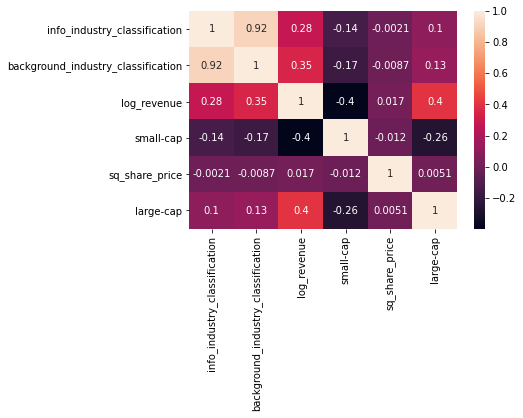

In [23]:
# check the heatmap for correlation
ax = sns.heatmap(train_X[predictors_1].corr(), annot=True)

In [24]:
############################################ Helper Function 9 ############################################################
def EvalModel(X, model):
  results = model.evals_result()
  epochs = len(results['validation_0']['merror'])
  x_axis = range(0, epochs)
  # plot loss
  fig, ax = plt.subplots(1,2, figsize=(20,5))
  ax[0].plot(x_axis, results['validation_0']['mlogloss'], label='Train')
  ax[0].plot(x_axis, results['validation_1']['mlogloss'], label='Validation')
  ax[0].legend()
  ax[0].set_title('XGBoost Loss')

  # VAR IMP
  df = pd.DataFrame({'Variables':X.columns, 'Feature Importance': model.feature_importances_})
  ax[1].bar(df['Variables'],df['Feature Importance'], color ='maroon')      
  ax[1].set_title('Feature Importance')
  plt.xticks(rotation='vertical')
  
  plt.show()



 Level 1: Industries




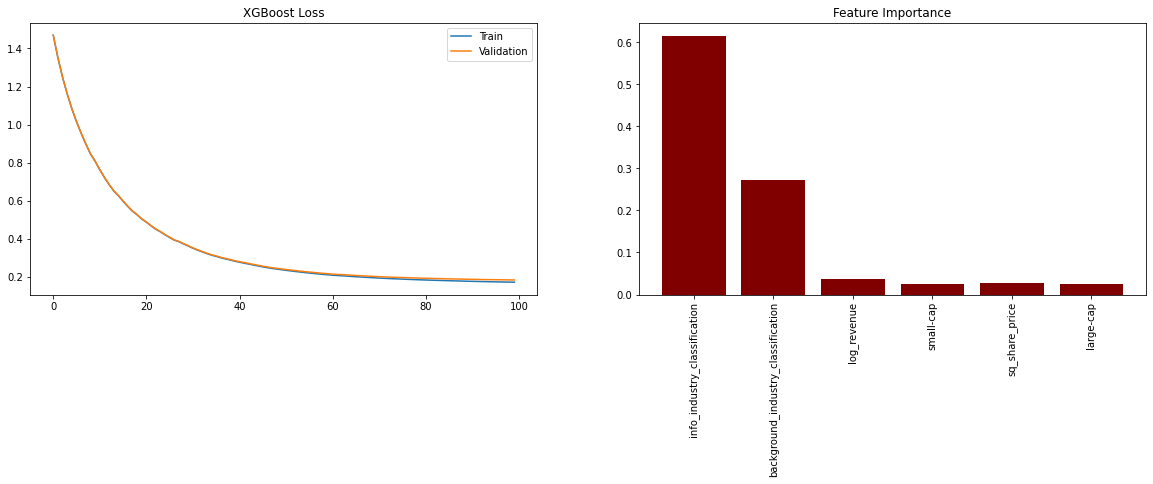



 Level 2: Types




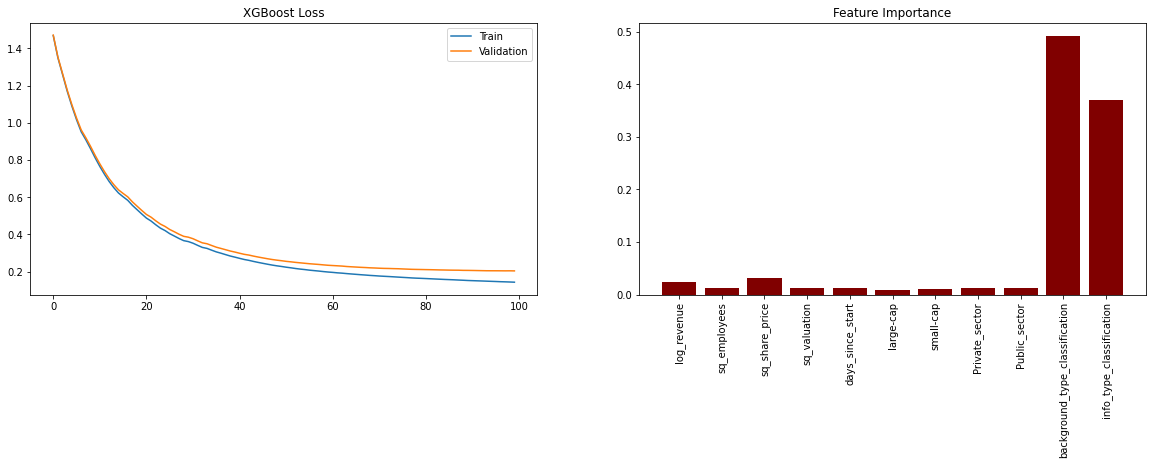

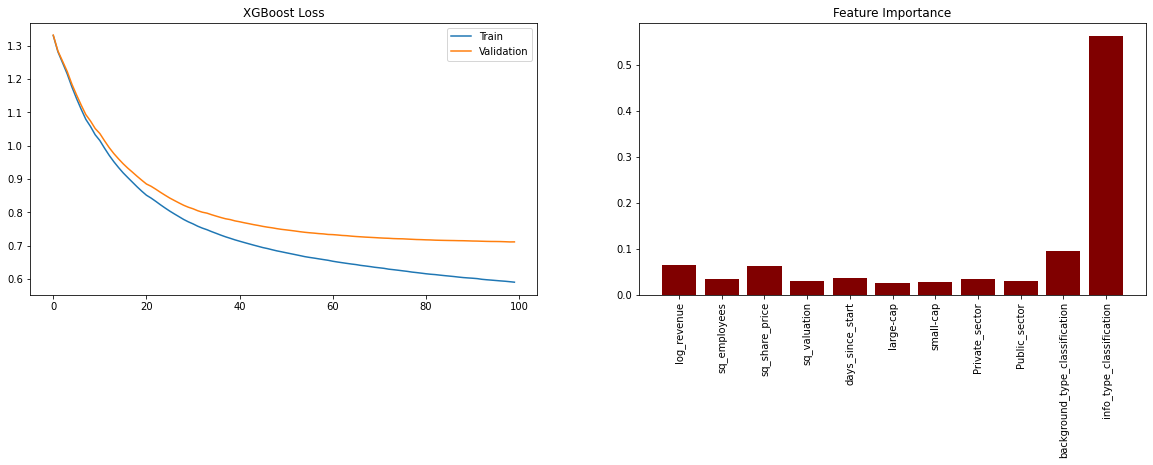

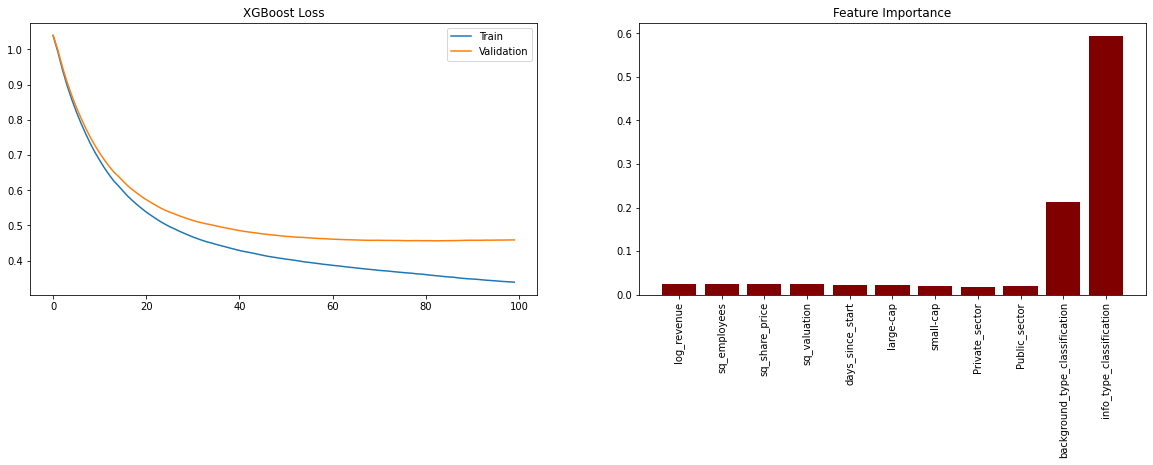

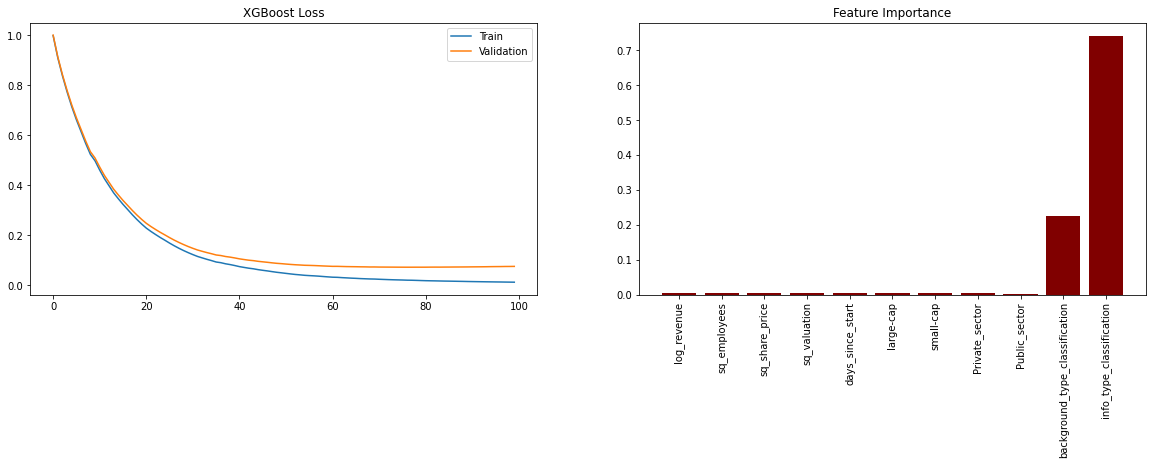

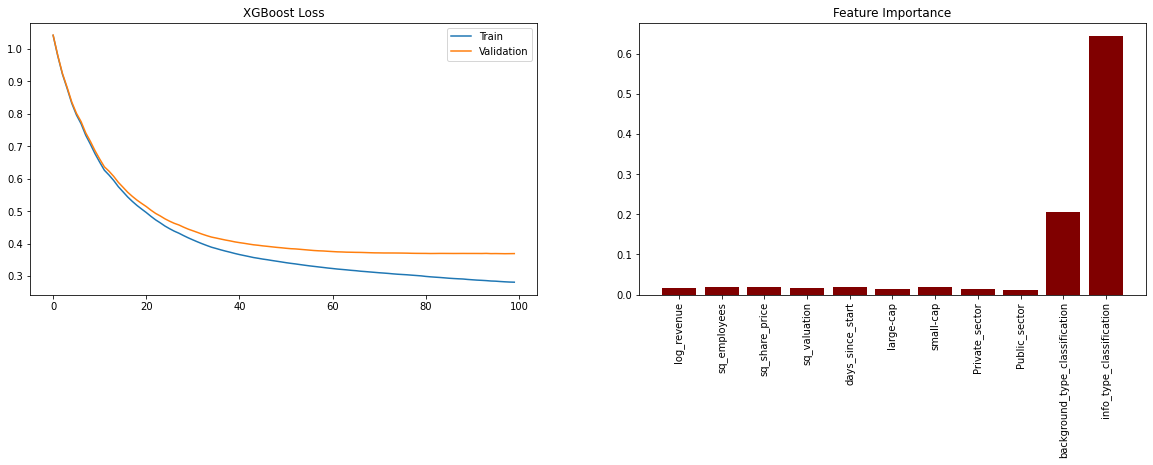



 Level 3: Products




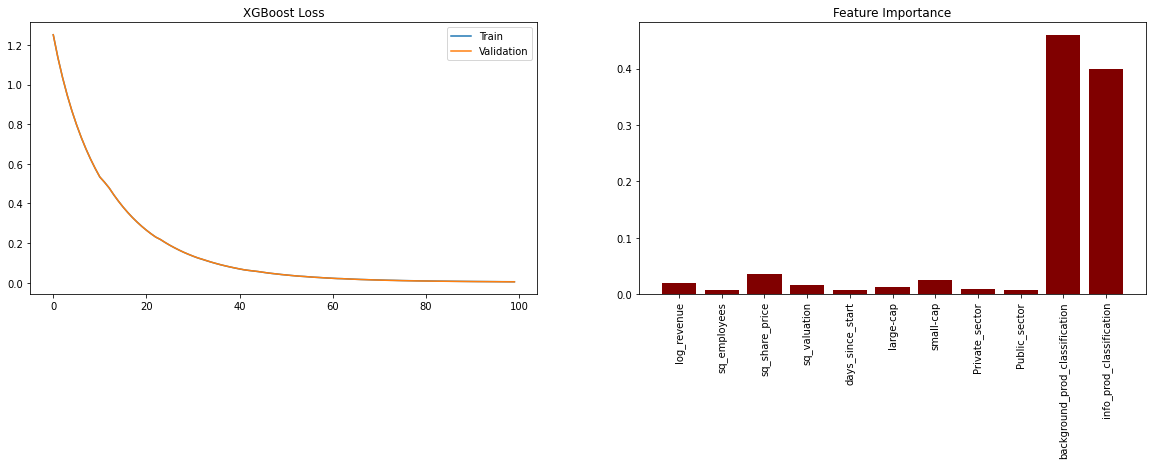

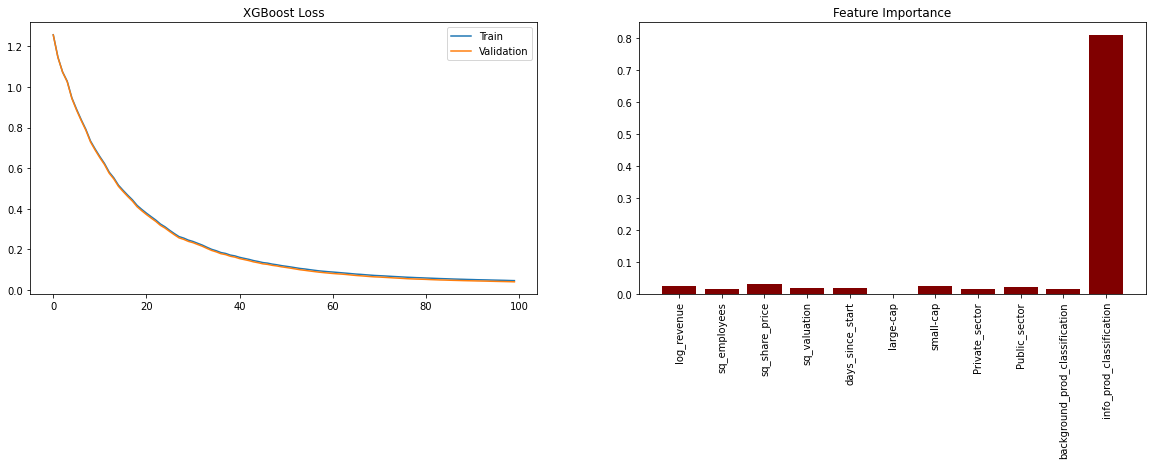

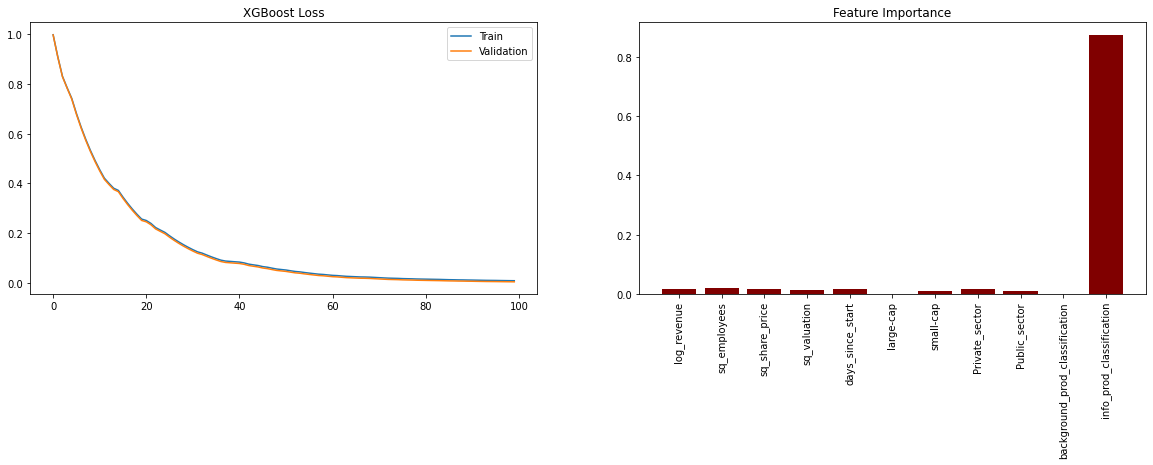

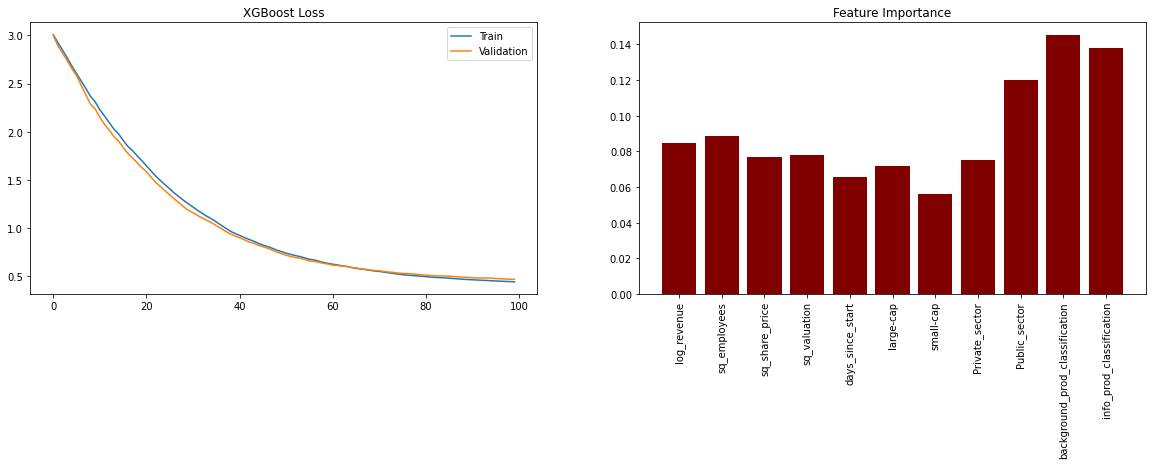

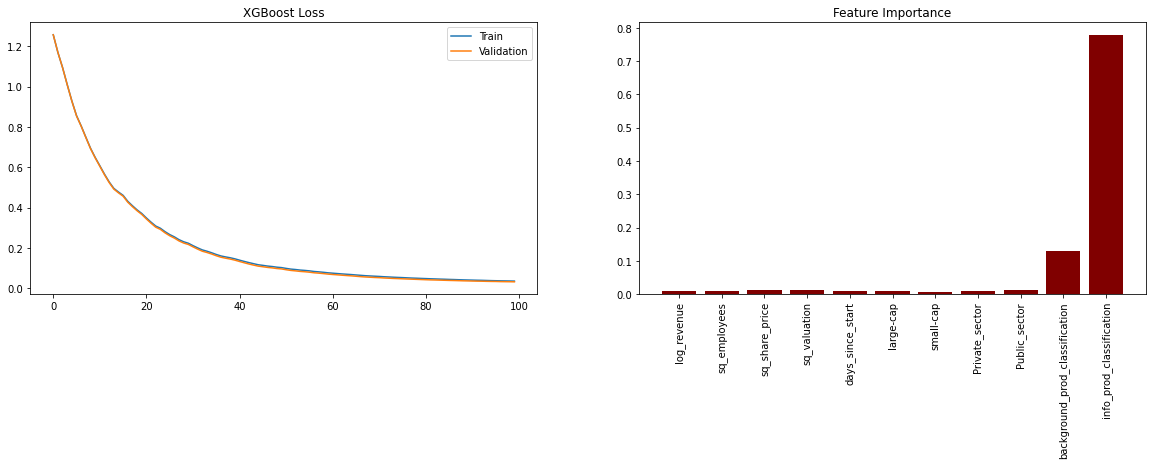

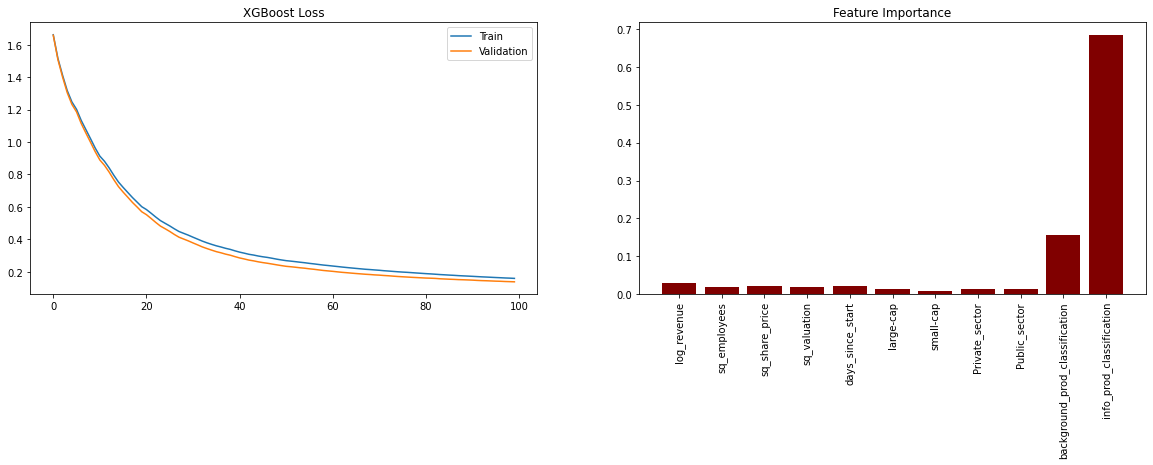

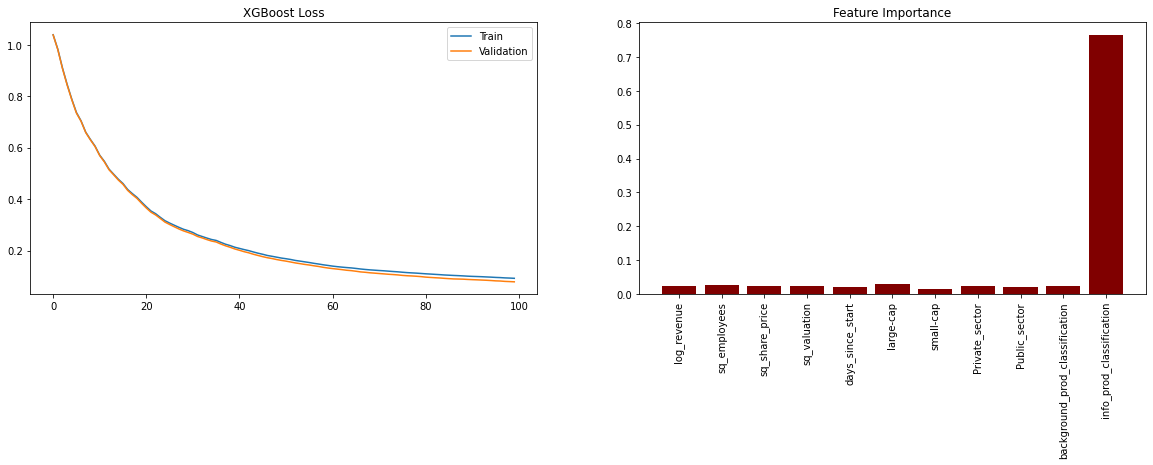

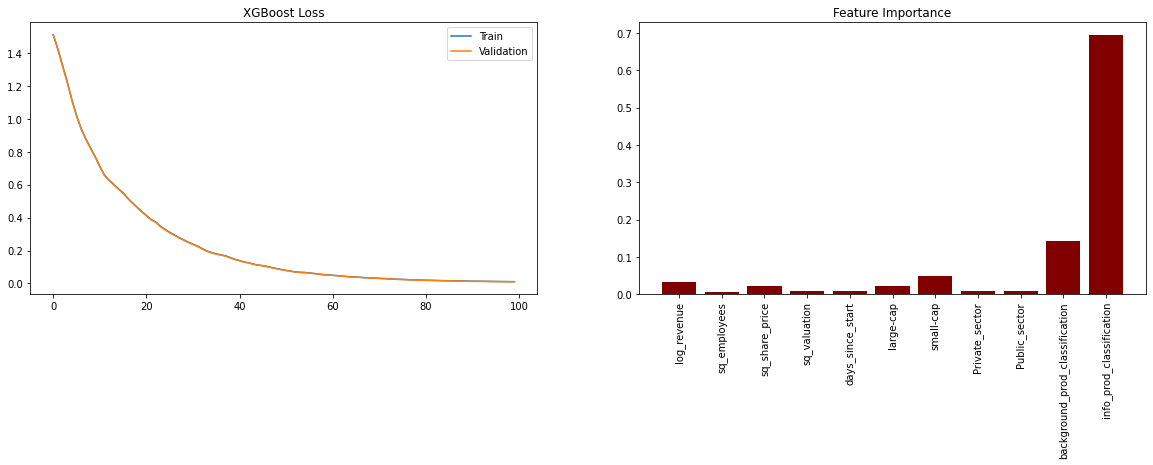

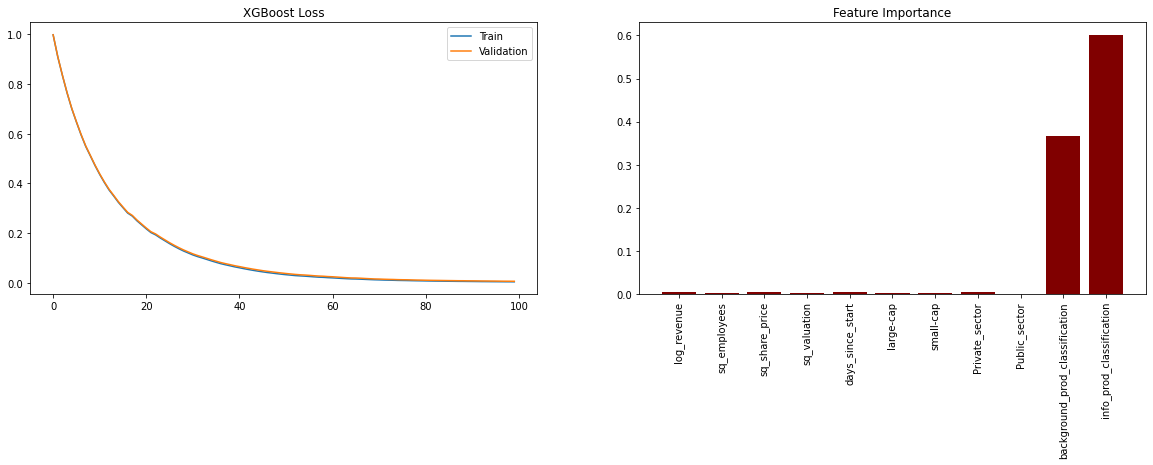

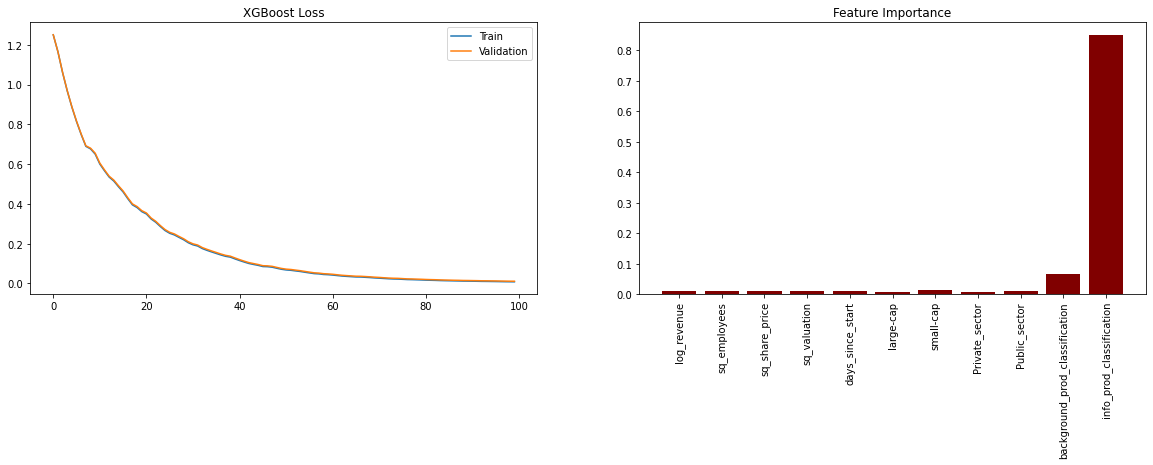

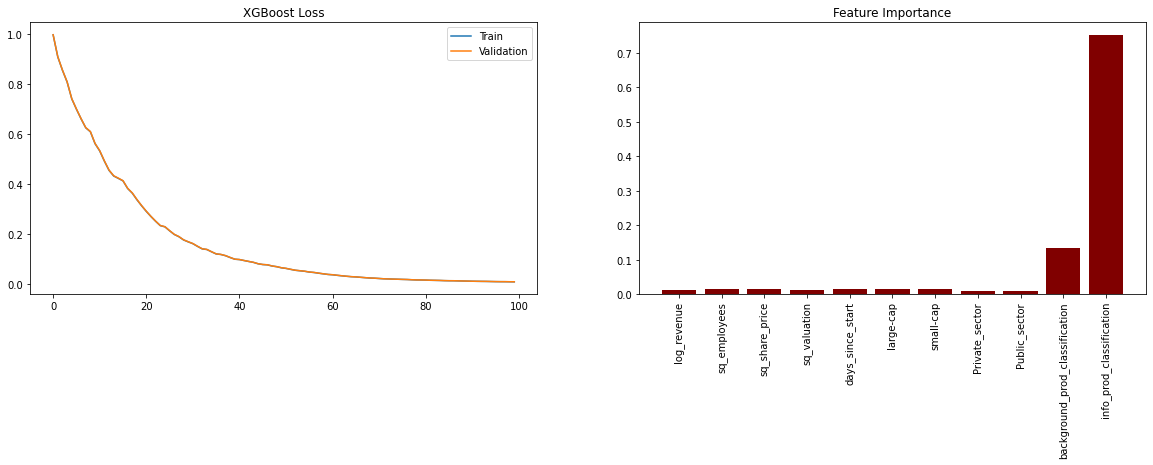

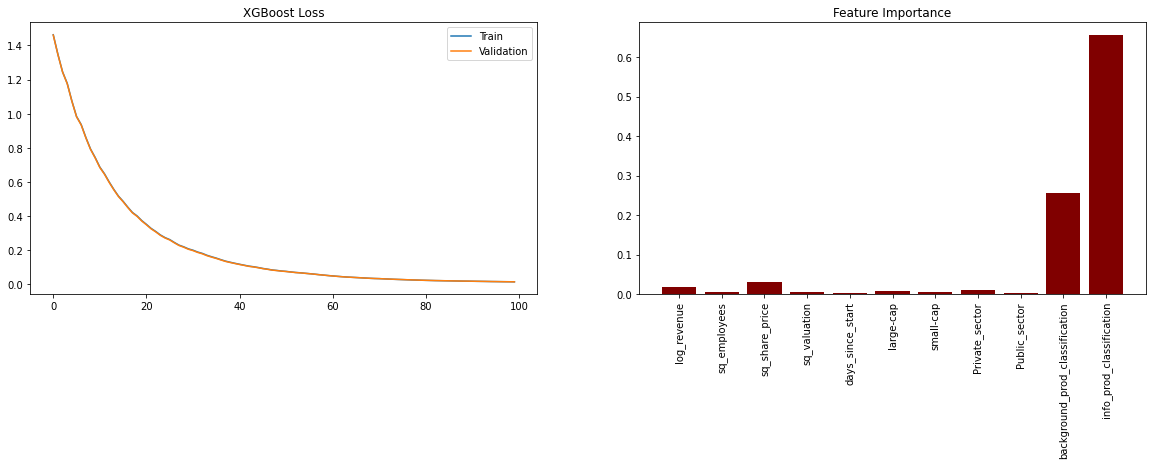

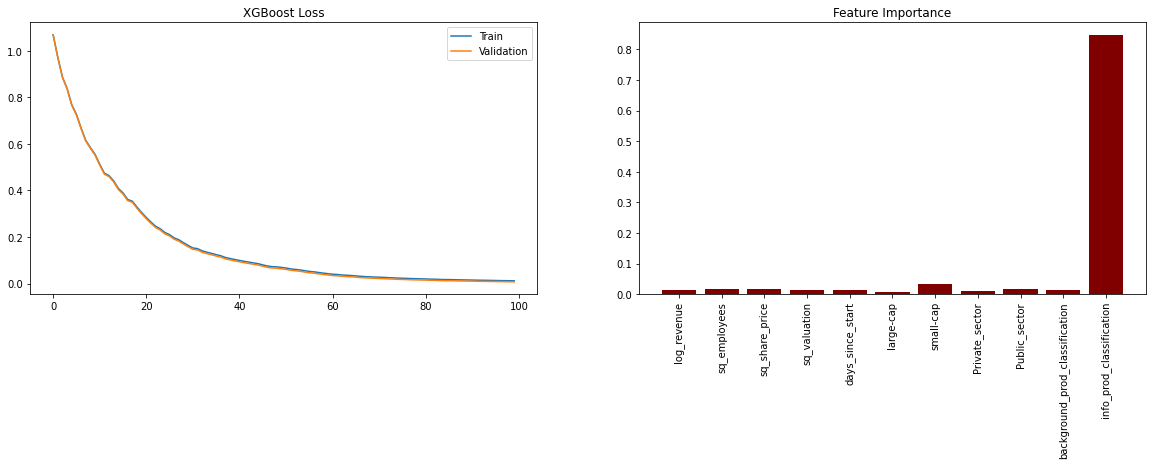

In [25]:
# check for trends in loss and var imp
print('\n\n Level 1: Industries\n\n')
EvalModel(train_X[predictors_1], model_1)

print('\n\n Level 2: Types\n\n')
for i in model_2.keys():
  EvalModel(train_X[predictors_2], model_2[i])

print('\n\n Level 3: Products\n\n')
for i in model_3.keys():
  if i==3: continue
  EvalModel(train_X[predictors_3], model_3[i])

## 8. Test Set Evaluation

In [26]:
# Step 1: Create same features like train set

data = FeatureEngg(test_df, False)

# Step 2: Text Classification Predict
text_classification = data[pd.notnull(data['Company_background'])]
text_classification['background_industry_classification'] = clf_dict['clf_model_back_industry'].predict(text_classification.Company_background)
text_classification['background_type_classification'] = clf_dict['clf_model_back_type'].predict(text_classification.Company_background)
text_classification['background_prod_classification'] = clf_dict['clf_model_back_prod'].predict(text_classification.Company_background)

text_classification = text_classification[['ID', 'background_industry_classification','background_type_classification',
                                            'background_prod_classification']]
data = data.merge(text_classification, how='left', on='ID')

text_classification = data[pd.notnull(data['Product_Information'])]
text_classification['info_industry_classification'] = clf_dict['clf_model_info_industry'].predict(text_classification.Product_Information)
text_classification['info_type_classification'] = clf_dict['clf_model_info_type'].predict(text_classification.Product_Information)
text_classification['info_prod_classification'] = clf_dict['clf_model_info_prod'].predict(text_classification.Product_Information)
text_classification = text_classification[['ID', 'info_industry_classification', 'info_type_classification',
                                            'info_prod_classification']]
data = data.merge(text_classification, how='left', on='ID')

cols = ['No.of employee', 'Revenue (Cr)', 'Net-valuation (Cr)', 'Share_price (RS)', 
        'log_revenue', 'sq_revenue', 'sq_employees', 'sq_valuation', 'sq_share_price',
        'No.of employee_capped','Net-valuation (Cr)_capped','Share_price (RS)_capped','Revenue (Cr)_capped',
        'days_since_start', 'large-cap', 'mid-cap', 'small-cap', 'Private_sector', 'Public_sector',
        'background_industry_classification','background_type_classification', 'background_prod_classification',
        'info_industry_classification', 'info_type_classification','info_prod_classification'] 


# STEP 3: create x
test_X  = CreateXY(data, cols,False)
test_X['ID'] = data['ID']


capped: 19
capped: 75
capped: 105
capped: 0


In [27]:
# STEP 4: predict
test_X['pred_industry'] = model_1.predict(test_X[predictors_1])
model_2_pred = {}
for i in ind_dict.keys():
  df = pd.DataFrame()
  df['ID'] = test_X[test_X['pred_industry']==ind_dict[i]]['ID']
  df['pred_type'] = model_2[ind_dict[i]].predict(test_X[test_X['pred_industry']==ind_dict[i]][predictors_2])
  model_2_pred[ind_dict[i]] = df

model_2_frames = [model_2_pred[i] for i in model_2_pred.keys()]
pred_type_df = pd.concat(model_2_frames)
test_X = test_X.merge(pred_type_df, how='left', on='ID') 


model_3_pred = {}
for i in type_dict.keys():
  df = pd.DataFrame()
  df['ID'] = test_X[test_X['pred_type']==type_dict[i]]['ID']
  if i=='toys': 
    df['pred_product'] = 4
  else:
    df['pred_product'] = model_3[type_dict[i]].predict(test_X[test_X['pred_type']==type_dict[i]][predictors_3])
  model_3_pred[type_dict[i]] = df

model_3_frames = [model_3_pred[i] for i in model_3_pred.keys()]
pred_prod_df = pd.concat(model_3_frames)
test_X = test_X.merge(pred_prod_df, how='left', on='ID') 

In [28]:
############################################ Helper Function 10 ############################################################

def id_to_cat(map):
  inv_map = {v: k for k, v in map.items()}
  return inv_map

In [29]:
# STEP 5: Create submission file

inv_ind = {0 : 'manufacturing' , 1 : 'computer' , 2 : 'health' , 3 : 'power' , 4 : 'automobile' }

inv_type = { 0 :'production' , 1 : 'food' , 2 : 'mechanical' , 3 : 'toys' , 4 : 'None' ,
           5 : 'hardware' , 6 : 'software' , 7 : 'security' , 8 : 'pharma' , 9 : 'diagnostic' ,
           10 : 'green energy' , 11 : 'non green energy' , 12 : 'light vehicles' , 13 : 'heavy vehicles' }

inv_prod = {0 : 'gaming hardware' , 1 : 'fastfood' , 2 : 'beverage' , 3 : 'bike' , 4 : 'kids toys' , 5 : 'None' ,
            6 : 'wiring tools' , 7 : 'medical devices' , 8 : 'organicfood' , 9 : 'hardware accelerator' ,
            10 : 'ai' , 11 : 'antivirus-security' , 12 : 'cyber-security' , 13 : 'it' , 14 : 'siddha' ,
            15 : 'allopathy' , 16 : 'homeopathic' , 17 : 'hydro' , 18 : 'wind' , 19 : 'fuel' ,
            20 : 'solar' , 21 : 'charcoal' , 22 : 'jcp' , 23 : 'truck' , 24 : 'car' }

submission = test_X[['ID', 'pred_industry','pred_type','pred_product']]
submission['pred_industry'] = submission['pred_industry'].map(inv_ind)
submission['pred_type'] = submission['pred_type'].map(inv_type)
submission['pred_product'] = submission['pred_product'].map(inv_prod)

col_names = {'ID':'ID', 'pred_industry': 'Industry', 'pred_type': 'Type', 'pred_product': 'Product'}
submission = submission.rename(columns = col_names)

submission.head(10)

,ID,Industry,Type,Product
0,PROJ0x51fa,manufacturing,production,gaming hardware
1,PROJ0x3c88,power,green energy,wind
2,PROJ0x3e72,computer,hardware,ai
3,PROJ0x1129,manufacturing,production,None
4,PROJ0x9029,automobile,heavy vehicles,jcp
5,PROJ0x24e2,power,non green energy,fuel
6,PROJ0x3375,manufacturing,production,gaming hardware
7,PROJ0x1331,manufacturing,food,beverage
8,PROJ0x7035,manufacturing,mechanical,wiring tools
9,PROJ0x1c3d,manufacturing,food,fastfood


In [30]:
submission.to_csv('Vidushi_Bhatia_18625_prediction.csv', index=False)

from google.colab import files
files.download('Vidushi_Bhatia_18625_prediction.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>